In [243]:
import os
import numpy as np
from dataclasses import dataclass, fields
from pyVASP.code.main import pyVASP

import pandas as pd
import ase
from ase.spacegroup import crystal

from pyiron.atomistics.structure.atoms import ase_to_pyiron
from pyiron.atomistics.structure.atoms import pyiron_to_ase

import matplotlib.pyplot as plt


# Define a custom formatting function for vectors in pandas
format_vector = lambda vector: '[' + ', '.join(['{:.10f}'.format(x) for x in vector]) + ']'

In [244]:
a = 3.95
alpha = 90
structure = crystal(('Ni', 'Mn', 'N'),
                       basis=[(0.00, 0.00, 0.00), (0.00, 0.50, 0.50), (0.50, 0.50, 0.50)],
                       spacegroup=221,
                       cellpar=[a, a, a, alpha, alpha, alpha])
structure.symbols.species()

{'Mn', 'N', 'Ni'}

In [245]:
Dtheta = 120 * np.pi/180
theta = -Dtheta
musite = 3

number_of_atoms = len(structure)
magdirs   = []
ms        = []
B_CONSTR  = []
for i in range(number_of_atoms):
   if 'Mn' == structure.get_chemical_symbols()[i]:
      theta += Dtheta
      magdirs.append(np.array([np.cos(theta), np.sin(theta), 0])*musite)
      ms.append(0)
      B_CONSTR.append([0, 0, 0])
   else:
      magdirs.append([0, 0, 0])
      ms.append(1)
      B_CONSTR.append([0, 0, 0])

In [246]:
structure.positions

array([[0.   , 0.   , 0.   ],
       [0.   , 1.975, 1.975],
       [1.975, 0.   , 1.975],
       [1.975, 1.975, 0.   ],
       [1.975, 1.975, 1.975]])

In [247]:
structure.new_array("magdirs", magdirs, dtype=float)
structure.new_array("ms", ms, dtype=float)
structure.new_array("B_CONSTR", B_CONSTR, dtype=float)

In [248]:
structure.positions[0] += [0.1,0.1,0.1]
structure.positions[1] += [0.1,0.1,0.1]

In [249]:
structure = structure.repeat((1,1,1))
# structure = ase_to_pyiron(structure)
# structure.set_repeat([2,2,2])
# structure = pyiron_to_ase(structure)

In [285]:
def set_vasp(m_val):
   a = 3.95
   alpha = 90
   structure = crystal(('Ni', 'Mn', 'N'),
                        basis=[(0.00, 0.00, 0.00), (0.00, 0.50, 0.50), (0.50, 0.50, 0.50)],
                        spacegroup=221,
                        cellpar=[a, a, a, alpha, alpha, alpha])

   Dtheta = 120 * np.pi/180
   theta = -Dtheta
   musite = 3

   number_of_atoms = len(structure)
   magdirs   = []
   ms        = []
   B_CONSTR  = []
   for i in range(number_of_atoms):
      if 'Mn' == structure.get_chemical_symbols()[i]:
         theta += Dtheta
         magdirs.append(np.array([np.cos(theta), np.sin(theta), 0])*musite)
         ms.append(m_val)
         B_CONSTR.append([0, 0, 0])
      else:
         magdirs.append([0, 0, 0])
         ms.append(1)
         B_CONSTR.append([0, 0, 0])

   structure.new_array("magdirs", magdirs, dtype=float)
   structure.new_array("ms", ms, dtype=float)
   structure.new_array("B_CONSTR", B_CONSTR, dtype=float)


   executable_path= "/home/emendive/workbench/work/from_claix/codes/VASP/vasp.5.4.4-flag4/bin"
   potential_path = "/home/emendive/workbench/work/from_claix/codes/VASP/potentials/potpaw_PBE"
   vasp = pyVASP(verbose="low", executable_path=executable_path, potential_path=potential_path, seed_mag="random")

   vasp.prepare_bfields()
   vasp.set_calculation(structure.copy())

   return vasp

def get_angles(vasp, I):
   magdir = np.array( vasp.df["magdirs"].tolist()[I] )
   magdir = magdir/np.linalg.norm(magdir)
   magmom = np.array( vasp.df["magmoms"].tolist()[I] )
   magmom = magmom/np.linalg.norm(magmom)

   cos_val = np.dot(magdir, magmom)
   theta = np.arccos(cos_val) * 180/np.pi

   magmom_inplane = magmom - magdir*cos_val
   dir_perp1 = np.array([0, 0, 1])
   dir_perp2 = np.cross(dir_perp1, magdir)

   comp1 = np.dot(magmom_inplane, dir_perp1)
   comp2 = np.dot(magmom_inplane, dir_perp2)

   phi = np.arctan2( comp1, comp2 ) * 180/np.pi

   return cos_val, theta, phi

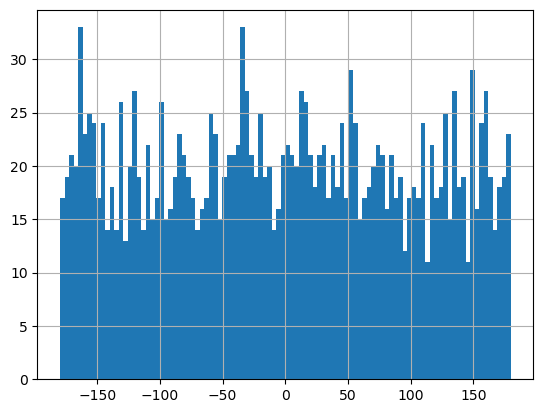

In [289]:
I = 2
m_val = 0.5
N = 2000

thetas = []
phis = []
for i in range(N):
   vasp = set_vasp(m_val)
   cos_val, theta, phi = get_angles(vasp, I)
   thetas.append(theta)
   phis.append(phi)

plt.hist(phis, bins=100)
plt.grid(visible=True)
plt.show()

In [279]:
0.81557222**2 + 0.2563249**2

0.7308605003957384

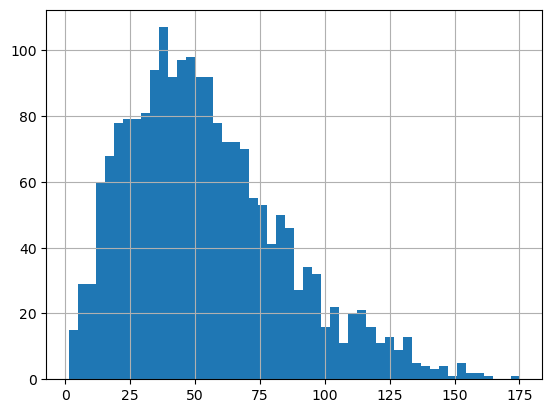

In [290]:
plt.hist(thetas, bins=50)
plt.grid(visible=True)
plt.show()

In [263]:
vasp.df

,elements,positions,magdirs,ms,betahs,magmoms,B_CONSTRs
3,Mn,"(1.975, 1.975, 0.0)","(-1.5000000000000013, -2.598076211353315, 0.0)",0.0,0.0,"(-1.065760563980706, -2.1439540373132564, 1.80...","(0.0, 0.0, 0.0)"
2,Mn,"(1.975, 0.0, 1.975)","(-1.4999999999999993, 2.598076211353316, 0.0)",0.0,0.0,"(-0.25374336144649057, -2.9091446891331576, 0....","(0.0, 0.0, 0.0)"
1,Mn,"(0.0, 1.975, 1.975)","(3.0, 0.0, 0.0)",0.0,0.0,"(-0.8466860645352341, 1.4635890127290185, -2.4...","(0.0, 0.0, 0.0)"
4,N,"(1.975, 1.975, 1.975)","(0.0, 0.0, 0.0)",1.0,inf,"(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0)"
0,Ni,"(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0)",1.0,inf,"(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0)"


In [252]:
magmoms = []

theta = np.pi/4
phi = np.pi/2
v = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
magmoms.append( vasp.magnetism.rotate_magmom([0, 0, 1], v) )

theta = 3*np.pi/4
phi = np.pi
v = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
magmoms.append( vasp.magnetism.rotate_magmom([0, 0, 1], v) )

theta = np.pi/2
phi = -np.pi/4
v = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
magmoms.append( vasp.magnetism.rotate_magmom([0, 0, 1], v) )

magmoms

[array([4.32978028e-17, 7.07106781e-01, 7.07106781e-01]),
 array([-7.07106781e-01,  8.65956056e-17, -7.07106781e-01]),
 array([ 7.07106781e-01, -7.07106781e-01,  6.12323400e-17])]

In [253]:
i_cell = 0
NumAtoms = 5
musize = 1
magmoms = np.zeros((3,3))

thetas = 0
phis = 0

alp=7/4*np.pi
mux= musize*np.sin(thetas)*np.cos(phis)
muy= musize*np.sin(thetas)*np.sin(phis)
muz= musize*np.cos(thetas)
magmoms[i_cell*NumAtoms+0, 0]= mux
magmoms[i_cell*NumAtoms+0, 1]= muy*np.cos(alp)-muz*np.sin(alp)
magmoms[i_cell*NumAtoms+0, 2]= muy*np.sin(alp)+muz*np.cos(alp)

alp=5/4*np.pi
mux= musize*np.sin(thetas)*np.cos(phis)
muy= musize*np.sin(thetas)*np.sin(phis)
muz= musize*np.cos(thetas)
magmoms[i_cell*NumAtoms+1, 0]= mux*np.cos(alp)+muz*np.sin(alp)
magmoms[i_cell*NumAtoms+1, 1]= muy
magmoms[i_cell*NumAtoms+1, 2]= -mux*np.cos(alp)+muz*np.sin(alp)

alp=1/4*np.pi
mux= musize*np.sin(thetas)*np.cos(phis)
muy= musize*np.sin(thetas)*np.sin(phis)
muz= musize*np.cos(thetas)
magmoms[i_cell*NumAtoms+2, 0]= mux*np.cos(alp)+muz*np.sin(alp)
magmoms[i_cell*NumAtoms+2, 1]= mux*np.sin(alp)-muz*np.cos(alp)
magmoms[i_cell*NumAtoms+2, 2]= -muy

magmoms

array([[ 0.        ,  0.70710678,  0.70710678],
       [-0.70710678,  0.        , -0.70710678],
       [ 0.70710678, -0.70710678, -0.        ]])

In [254]:
np.dot(magmoms[1], magmoms[2])

-0.4999999999999999

In [255]:
vasp.prepare_bfields()
vasp.set_calculation(structure.copy())

In [256]:
vasp.df

,elements,positions,magdirs,ms,betahs,magmoms,B_CONSTRs
3,Mn,"(1.975, 1.975, 0.0)","(-1.5000000000000013, -2.598076211353315, 0.0)",0.0,0.0,"(-1.3463046061227935, 2.5300321171709292, 0.88...","(0.0, 0.0, 0.0)"
2,Mn,"(1.975, 0.0, 1.975)","(-1.4999999999999993, 2.598076211353316, 0.0)",0.0,0.0,"(1.7054565210019723, -2.4339106039609453, -0.4...","(0.0, 0.0, 0.0)"
1,Mn,"(0.1, 2.075, 2.075)","(3.0, 0.0, 0.0)",0.0,0.0,"(-0.8043235865371232, -2.871306106422751, 0.32...","(0.0, 0.0, 0.0)"
4,N,"(1.975, 1.975, 1.975)","(0.0, 0.0, 0.0)",1.0,inf,"(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0)"
0,Ni,"(0.1, 0.1, 0.1)","(0.0, 0.0, 0.0)",1.0,inf,"(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0)"


In [257]:
vasp.restart_from_charge(kpoints="3 2 2", LAMBDA=3)

In [258]:
vasp.io.potential_files.Mn

'Mn_pv'

In [259]:
this_dir = os.getcwd()
vasp.restart_from_charge(cwd_new=this_dir+"/aaa", kpoints="3 3 3", LAMBDA=7)

cp: cannot stat 'CHGCAR': No such file or directory
cp: cannot stat 'CHG': No such file or directory
cp: cannot stat 'WAVECAR': No such file or directory


In [260]:
this_dir

'/home/emendive/workbench/devel/gitclones/pyVASP/notebooks/tests'